In [1]:
# Cell 1: Imports
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import os
import sys
from datetime import datetime

print("Basic imports completed.")

Basic imports completed.


In [2]:
# Cell 1: Imports
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import os
import sys
from datetime import datetime
import optuna

# Sklearn imports
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier

# Third-party libraries
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb

print("Imports completed.")

Imports completed.


In [3]:
# Cell 2: Setup and Configuration
# ==================================================

# Configuration
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Paths
PROJECT_ROOT = Path('../../') 
MODELS_DIR = Path('models')
VIZ_DIR = PROJECT_ROOT / 'visualizations/match_winner'
DATASETS_DIR = PROJECT_ROOT / 'Task_Files/datasets'
RAW_MATCH_DATA_PATH = DATASETS_DIR / 'Match Winner.csv'
FINAL_DATA_PATH = PROJECT_ROOT / 'Task_Files/data/match_winner/match_winner_data.csv'
REPORTS_DIR = PROJECT_ROOT / 'reports/match_winner'
DIAG_DIR = REPORTS_DIR / 'diagnostics'

# Create directories
for dir_path in [MODELS_DIR, VIZ_DIR, FINAL_DATA_PATH.parent, REPORTS_DIR, DIAG_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.2

print("="*80)
print("SETUP COMPLETED")
print("="*80)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Models Dir: {MODELS_DIR}")
print(f"Data Path: {RAW_MATCH_DATA_PATH}")

SETUP COMPLETED
Timestamp: 2025-12-04 23:22:40
Project Root: ..\..
Models Dir: models
Data Path: ..\..\Task_Files\datasets\Match Winner.csv


In [10]:
# Cell 3: Data Loading
# ==================================================

print("\n" + "="*80)
print("DATA LOADING")
print("="*80)

if not RAW_MATCH_DATA_PATH.exists():
    raise FileNotFoundError(f"File not found: {RAW_MATCH_DATA_PATH}")
    
print(f"\n📂 Loading data from: {RAW_MATCH_DATA_PATH}")
df = pd.read_csv(RAW_MATCH_DATA_PATH)

# Standardize columns
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Standardize target column
possible_target_names = {
    'ftr': 'match_outcome',
    'result': 'match_outcome',
    'final_result': 'match_outcome',
    'match_result': 'match_outcome'
}

renamed = False
for name, new_name in possible_target_names.items():
    if name in df.columns and new_name not in df.columns:
        df.rename(columns={name: new_name}, inplace=True)
        print(f"✓ Standardized target column: Renamed '{name}' to '{new_name}'")
        renamed = True
        break
        
if 'match_outcome' not in df.columns:
    print("! WARNING: Target column 'match_outcome' not found or standardized. Please check the CSV file.")

# Create summary table
print("\n" + "="*80)
print("DATA SUMMARY")
print("="*80)

summary_data = {
    'Metric': ['Rows', 'Columns', 'Memory Usage', 'Missing Values', 'Duplicate Rows'],
    'Value': [
        df.shape[0],
        df.shape[1],
        f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB",
        df.isnull().sum().sum(),
        df.duplicated().sum()
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Display sample data
print("\n" + "="*80)
print("SAMPLE DATA (First 5 Rows)")
print("="*80)
display(df.head())

# Column information table
print("\n" + "="*80)
print("COLUMN INFORMATION")
print("="*80)

col_info = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Non-Null Count': df.count().values,
    'Null Count': df.isnull().sum().values,
    'Unique Values': [df[col].nunique() for col in df.columns]
})

print(col_info.to_string(index=False))


DATA LOADING

📂 Loading data from: ..\..\Task_Files\datasets\Match Winner.csv
✓ Standardized target column: Renamed 'ftr' to 'match_outcome'

DATA SUMMARY
        Metric   Value
          Rows    6840
       Columns      40
  Memory Usage 6.67 MB
Missing Values       0
Duplicate Rows       0

SAMPLE DATA (First 5 Rows)


,unnamed:_0,date,hometeam,awayteam,fthg,ftag,match_outcome,htgs,atgs,htgc,atgc,htp,atp,hm1,hm2,hm3,hm4,hm5,am1,am2,am3,am4,am5,mw,htformptsstr,atformptsstr,htformpts,atformpts,htwinstreak3,htwinstreak5,htlossstreak3,htlossstreak5,atwinstreak3,atwinstreak5,atlossstreak3,atlossstreak5,htgd,atgd,diffpts,diffformpts
0,0,19/08/00,Charlton,Man City,4,0,H,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,1,19/08/00,Chelsea,West Ham,4,2,H,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2,19/08/00,Coventry,Middlesbrough,1,3,NH,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,3,19/08/00,Derby,Southampton,2,2,NH,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,4,19/08/00,Leeds,Everton,2,0,H,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0



COLUMN INFORMATION
       Column Data Type  Non-Null Count  Null Count  Unique Values
   unnamed:_0     int64            6840           0           6840
         date    object            6840           0           1804
     hometeam    object            6840           0             44
     awayteam    object            6840           0             44
         fthg     int64            6840           0             10
         ftag     int64            6840           0              8
match_outcome    object            6840           0              2
         htgs     int64            6840           0             96
         atgs     int64            6840           0             92
         htgc     int64            6840           0             81
         atgc     int64            6840           0             80
          htp   float64            6840           0            833
          atp   float64            6840           0            835
          hm1    object            6840   

In [5]:
# Cell 4: Data Cleaning
# ==================================================

print("\n" + "="*80)
print("DATA CLEANING")
print("="*80)

print("Data Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum()[df.isnull().sum() > 0])
print("\nDuplicate Rows:", df.duplicated().sum())

# Check for constant columns
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
if constant_cols:
    print("\nConstant Columns (to drop):", constant_cols)
else:
    print("\nNo constant columns found.")

if df.duplicated().sum() > 0:
    print(f"\nRemoving {df.duplicated().sum()} duplicate rows...")
    df = df.drop_duplicates()
    print("Duplicates removed.")


DATA CLEANING
Data Shape: (6840, 40)

Missing Values:
 Series([], dtype: int64)

Duplicate Rows: 0

No constant columns found.



EXPLORATORY DATA ANALYSIS (EDA)
Temporarily encoded 'match_outcome' for visualization.

Distribution of Target Variable: 'match_outcome'


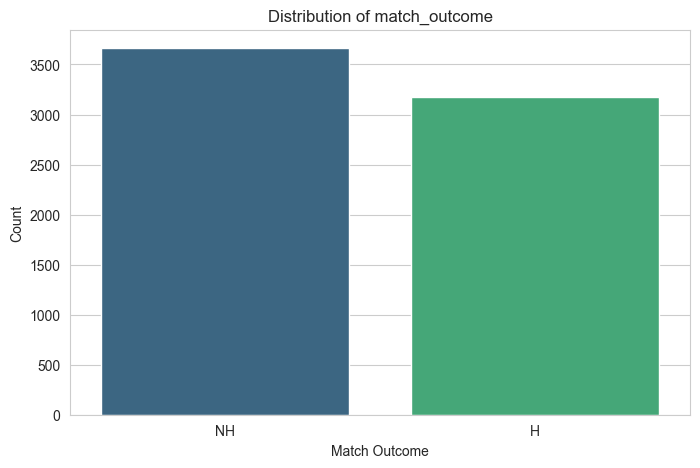


Generating Correlation Matrix for a curated subset of non-betting features...
-> Plotting correlation for 12 features.


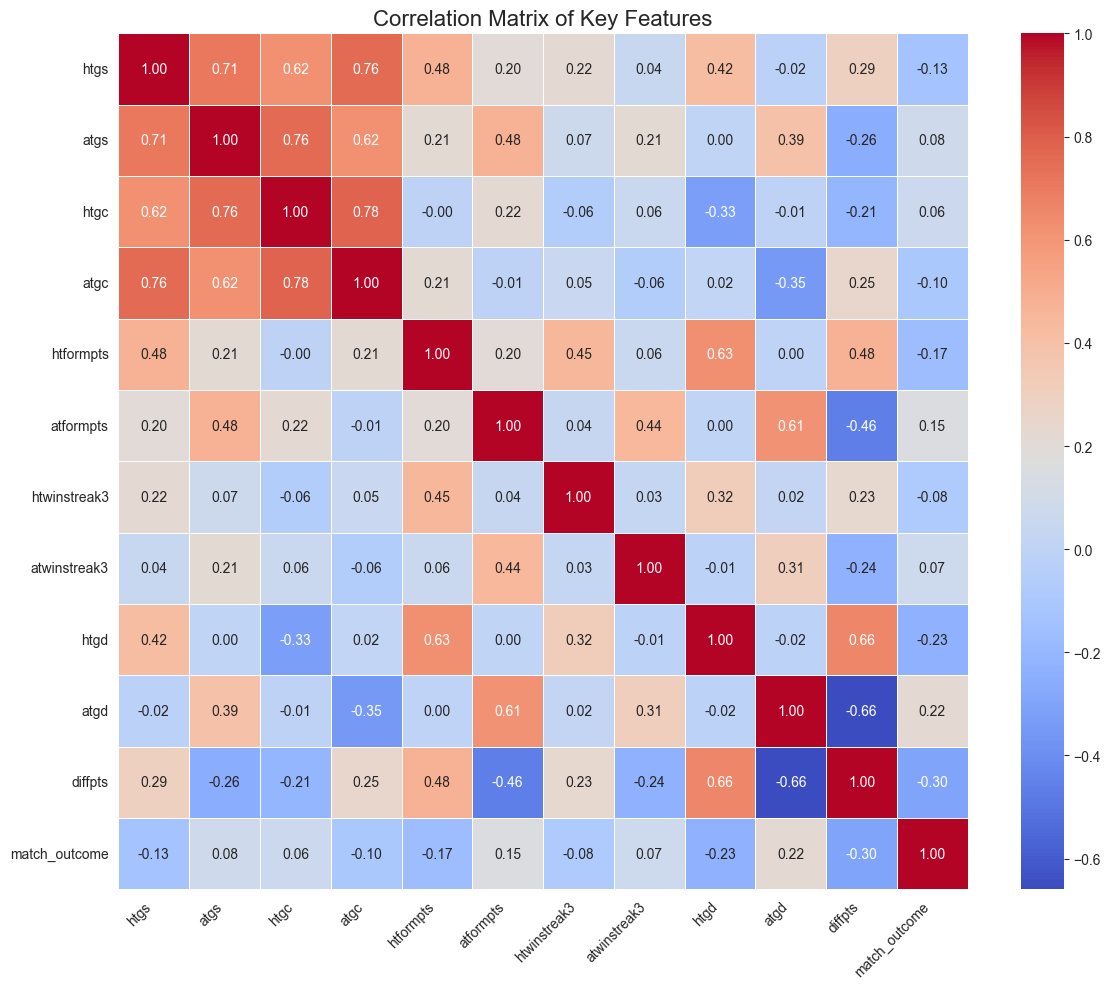

In [6]:
# Cell 5: Exploratory Data Analysis (EDA)
# ==================================================

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*80)

target_col = 'match_outcome'

# --- Target Distribution ---
df_eda = df.copy()
le = LabelEncoder()

if target_col in df_eda.columns and df_eda[target_col].dtype == 'object':
    df_eda[target_col] = le.fit_transform(df_eda[target_col])
    print(f"Temporarily encoded '{target_col}' for visualization.")

print(f"\nDistribution of Target Variable: '{target_col}'")
plt.figure(figsize=(8, 5))
sns.countplot(x=target_col, data=df, palette='viridis', order=df[target_col].value_counts().index)
plt.title(f'Distribution of {target_col}')
plt.xlabel('Match Outcome')
plt.ylabel('Count')
plt.show()

# --- Correlation Matrix on a Curated Subset of Non-Betting Features ---
print("\nGenerating Correlation Matrix for a curated subset of non-betting features...")

curated_features = [
    # Key engineered features (if they exist yet, or raw features)
    'htgs', 'atgs', 'htgc', 'atgc', 'htformpts', 'atformpts',
    'htwinstreak3', 'atwinstreak3', 'htgd', 'atgd', 'diffpts',
    # Target column
    target_col
]

# Filter to only features that actually exist in the dataframe
existing_curated_features = [f for f in curated_features if f in df_eda.columns]

if existing_curated_features:
    print(f"-> Plotting correlation for {len(existing_curated_features)} features.")
    
    plt.figure(figsize=(12, 10))
    corr_df = df_eda[existing_curated_features].copy()
    corr_df.dropna(axis=1, how='all', inplace=True)
    
    if not corr_df.empty:
        corr_matrix = corr_df.corr()
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            linewidths=0.5,
            annot_kws={"size": 10}
        )
        plt.title('Correlation Matrix of Key Features', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("! All selected columns for correlation were empty. Skipping heatmap.")
else:
    print("! Could not find any of the curated features for correlation analysis. Skipping heatmap.")

In [7]:
# Cell 6: Feature Engineering
# ==================================================

print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Convert match result columns to numeric if needed (W=3, D=1, L=0)
match_cols = ['hm1', 'hm2', 'hm3', 'hm4', 'hm5', 'am1', 'am2', 'am3', 'am4', 'am5']
for col in match_cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].map({'W': 3, 'D': 1, 'L': 0}).fillna(0).astype(float)

# 1-2. Current Points
df['Home_Current_Points'] = df['htp']
df['Away_Current_Points'] = df['atp']

# 3-6. Goals Scored/Conceded
df['Home_Goals_Scored'] = df['htgs']
df['Away_Goals_Scored'] = df['atgs']
df['Home_Goals_Conceded'] = df['htgc']
df['Away_Goals_Conceded'] = df['atgc']

# 7-8. Goal Difference
df['Home_Goal_Difference'] = df['htgd']
df['Away_Goal_Difference'] = df['atgd']

# 9-10. Recent Form (Points in last 5 games)
df['Home_Recent_Points'] = df['htformpts']
df['Away_Recent_Points'] = df['atformpts']

# 11-12. Win Streaks
df['Home_Win_Streak'] = df['htwinstreak3']
df['Away_Win_Streak'] = df['atwinstreak3']

# 13-15. Gaps/Differences (Intuitive comparisons)
df['Points_Gap'] = df['Home_Current_Points'] - df['Away_Current_Points']
df['Form_Gap'] = df['Home_Recent_Points'] - df['Away_Recent_Points']
df['Goal_Difference_Gap'] = df['Home_Goal_Difference'] - df['Away_Goal_Difference']

print("✓ Created 15 simple features:")
print("  • Current Standing: Home_Current_Points, Away_Current_Points, Points_Gap")
print("  • Goals: Home_Goals_Scored, Away_Goals_Scored, Home_Goals_Conceded, Away_Goals_Conceded")
print("  • Goal Difference: Home_Goal_Difference, Away_Goal_Difference, Goal_Difference_Gap")
print("  • Recent Form: Home_Recent_Points, Away_Recent_Points, Form_Gap")
print("  • Streaks: Home_Win_Streak, Away_Win_Streak")
print("="*80)

df.to_csv(FINAL_DATA_PATH, index=False)
print(f"✓ Data saved to {FINAL_DATA_PATH}")


FEATURE ENGINEERING
✓ Created 15 simple features:
  • Current Standing: Home_Current_Points, Away_Current_Points, Points_Gap
  • Goals: Home_Goals_Scored, Away_Goals_Scored, Home_Goals_Conceded, Away_Goals_Conceded
  • Goal Difference: Home_Goal_Difference, Away_Goal_Difference, Goal_Difference_Gap
  • Recent Form: Home_Recent_Points, Away_Recent_Points, Form_Gap
  • Streaks: Home_Win_Streak, Away_Win_Streak
✓ Data saved to ..\..\Task_Files\data\match_winner\match_winner_data.csv


In [8]:
# Cell 7: Preprocessing and Train/Test Split
# ==================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

print("\n" + "="*80)
print("DATA PREPROCESSING (10 REFINED FEATURES)")
print("="*80)

target_col = 'match_outcome'

# 1. Handle Target
le = LabelEncoder()
y = le.fit_transform(df[target_col])
class_names = list(le.classes_)
print(f"✓ Target classes: {dict(enumerate(class_names))}")

# 2. Define the EXACT 10 non-redundant features
refined_features = [
    'Points_Gap',           # Replaces Home/Away Current Points
    'Goal_Difference_Gap',  # Replaces raw GD
    'Form_Gap',             # Replaces Home/Away Recent Points
    'Home_Goal_Difference', # Kept for specific home context
    'Away_Goal_Difference', # Kept for specific away context
    'Home_Win_Streak',      # Momentum
    'Away_Win_Streak',      # Momentum
    'Home_Goals_Scored',    # Attack strength
    'Away_Goals_Scored',    # Attack strength
    'Home_Goals_Conceded'   # Defense weakness
]

# Check for missing features
missing = [f for f in refined_features if f not in df.columns]
if missing:
    print(f"! WARNING: Missing features: {missing}")
    print("  Make sure you ran 'engineer_simple_features' first!")

# Select ONLY these features
X = df[refined_features].copy()
X = X.fillna(0)

print(f"✓ Selected {X.shape[1]} refined features")

# 3. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# 4. Scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 5. SMOTE
print("\nApplying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Training Shape: {X_train_resampled.shape}")
print(f"Testing Shape: {X_test_scaled.shape}")


DATA PREPROCESSING (10 REFINED FEATURES)
✓ Target classes: {0: 'H', 1: 'NH'}
✓ Selected 10 refined features

Applying SMOTE to handle class imbalance...
Training Shape: (5862, 10)
Testing Shape: (1368, 10)


In [9]:
# Cell 8: Model Training and Tuning
# ==================================================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
import xgboost as xgb
import optuna

print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

def tune_hyperparameters(model_class, X_train, y_train, param_fn, n_trials=20, cv=7, scoring='f1_macro', task_type='classification'):
    def objective(trial):
        params = param_fn(trial)
        model = model_class(**params)
        
        if task_type == 'classification':
            cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
        else:
            cv_strategy = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
            
        scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring=scoring, n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
        
    return study.best_params

best_models = {}

# 1. Logistic Regression
print("\n--- Tuning Logistic Regression ---")
def lr_params(trial):
    return {
        'C': trial.suggest_float('C', 0.01, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'max_iter': 1000
    }
lr_best_params = tune_hyperparameters(
    LogisticRegression, X_train_resampled, y_train_resampled, lr_params, n_trials=20, scoring='f1_macro'
)
lr_model = LogisticRegression(**lr_best_params)
lr_model.fit(X_train_resampled, y_train_resampled)
best_models['LogisticRegression'] = lr_model

# 2. Random Forest
print("\n--- Tuning Random Forest ---")
def rf_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
rf_best_params = tune_hyperparameters(
    RandomForestClassifier, X_train_resampled, y_train_resampled, rf_params, n_trials=30, scoring='f1_macro'
)
rf_model = RandomForestClassifier(**rf_best_params)
rf_model.fit(X_train_resampled, y_train_resampled)
best_models['RandomForest'] = rf_model

# 3. XGBoost
print("\n--- Tuning XGBoost ---")
def xgb_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
xgb_best_params = tune_hyperparameters(
    xgb.XGBClassifier, X_train_resampled, y_train_resampled, xgb_params, n_trials=30, scoring='f1_macro'
)
xgb_model = xgb.XGBClassifier(**xgb_best_params)
xgb_model.fit(X_train_resampled, y_train_resampled)
best_models['XGBoost'] = xgb_model
    
# 4. Gradient Boosting
print("\n--- Tuning Gradient Boosting ---")
def gb_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': RANDOM_STATE
    }
gb_best_params = tune_hyperparameters(
    GradientBoostingClassifier, X_train_resampled, y_train_resampled, gb_params, n_trials=30, scoring='f1_macro'
)
gb_model = GradientBoostingClassifier(**gb_best_params)
gb_model.fit(X_train_resampled, y_train_resampled)
best_models['GradientBoosting'] = gb_model
    
# 5. Neural Network (Deeper MLPClassifier)
print("\n--- Tuning Deep Neural Network (MLP) ---")
def mlp_params(trial):
    layer1 = trial.suggest_int('layer1', 128, 512, step=64)
    layer2 = trial.suggest_int('layer2', 64, 256, step=32)
    layer3 = trial.suggest_int('layer3', 32, 128, step=32)
    return {
        'hidden_layer_sizes': (layer1, layer2, layer3),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'alpha': trial.suggest_float('alpha', 0.0001, 0.01, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.01, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['adaptive', 'constant']),
        'max_iter': 500,
        'early_stopping': True,
        'validation_fraction': 0.15,
        'random_state': RANDOM_STATE
    }
mlp_best_params_raw = tune_hyperparameters(
    MLPClassifier, X_train_resampled, y_train_resampled, mlp_params, n_trials=30, scoring='f1_macro'
)
# Manually construct the correct parameters
mlp_best_params = {
    'hidden_layer_sizes': (mlp_best_params_raw['layer1'], mlp_best_params_raw['layer2'], mlp_best_params_raw['layer3']),
    'activation': mlp_best_params_raw['activation'],
    'alpha': mlp_best_params_raw['alpha'],
    'learning_rate_init': mlp_best_params_raw['learning_rate_init'],
    'learning_rate': mlp_best_params_raw['learning_rate'],
    'max_iter': 500,
    'early_stopping': True,
    'validation_fraction': 0.15,
    'random_state': RANDOM_STATE
}
mlp_model = MLPClassifier(**mlp_best_params)
mlp_model.fit(X_train_resampled, y_train_resampled)
print("✓ Deep Neural Network training complete.")
best_models['NeuralNetwork'] = mlp_model

# 6. Stacking Ensemble (Meta-Learner)
print("\n--- Building Stacking Ensemble ---")

base_estimators = [
    ('rf', best_models['RandomForest']),
    ('lr', best_models['LogisticRegression']),
    ('xgb', best_models['XGBoost']),
    ('gb', best_models['GradientBoosting']),
    ('nn', best_models['NeuralNetwork'])
]

# Use Logistic Regression as meta-learner
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(C=1.0, max_iter=1000, random_state=RANDOM_STATE),
    cv=7,
    n_jobs=-1
)
print(f"Training stacking ensemble with {len(base_estimators)} base models...")
stacking_model.fit(X_train_resampled, y_train_resampled)
best_models['StackingEnsemble'] = stacking_model
print("✓ Stacking Ensemble training complete.")

[I 2025-12-04 23:22:41,435] A new study created in memory with name: no-name-6cd23493-8bdb-40c3-a4c2-6f62f15083b9



MODEL TRAINING

--- Tuning Logistic Regression ---


[I 2025-12-04 23:22:43,257] Trial 0 finished with value: 0.6249032050689093 and parameters: {'C': 0.7864273897065213, 'solver': 'lbfgs', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6249032050689093.
[I 2025-12-04 23:22:44,714] Trial 1 finished with value: 0.6254160269640611 and parameters: {'C': 2.859129468222232, 'solver': 'lbfgs', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6254160269640611.
[I 2025-12-04 23:22:44,714] Trial 1 finished with value: 0.6254160269640611 and parameters: {'C': 2.859129468222232, 'solver': 'lbfgs', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6254160269640611.
[I 2025-12-04 23:22:45,752] Trial 2 finished with value: 0.626953014916299 and parameters: {'C': 0.07407699925457467, 'solver': 'lbfgs', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.626953014916299.
[I 2025-12-04 23:22:45,752] Trial 2 finished with value: 0.626953014916299 and parameters: {'C': 0.07407699925457467, 'solver': 'lbfgs', 'class_wei

Best trial:
  Value: 0.6307457925394291
  Params: 
    C: 0.011406465214697407
    solver: liblinear
    class_weight: balanced

--- Tuning Random Forest ---


[I 2025-12-04 23:22:47,778] Trial 0 finished with value: 0.6307805861779842 and parameters: {'n_estimators': 246, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6307805861779842.
[I 2025-12-04 23:22:49,712] Trial 1 finished with value: 0.6286978526782722 and parameters: {'n_estimators': 320, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.6307805861779842.
[I 2025-12-04 23:22:49,712] Trial 1 finished with value: 0.6286978526782722 and parameters: {'n_estimators': 320, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.6307805861779842.
[I 2025-12-04 23:22:51,627] Trial 2 finished with value: 0.6275639085377532 and parameters: {'n_estimators': 358, 'max_depth': 15, 'min_samples

Best trial:
  Value: 0.6348761814115002
  Params: 
    n_estimators: 446
    max_depth: 20
    min_samples_split: 4
    min_samples_leaf: 2
    max_features: log2
    class_weight: balanced


[I 2025-12-04 23:24:00,719] A new study created in memory with name: no-name-d80661d1-7167-419f-92af-483d85c35737



--- Tuning XGBoost ---


[I 2025-12-04 23:24:01,339] Trial 0 finished with value: 0.6241816634035657 and parameters: {'n_estimators': 405, 'max_depth': 12, 'learning_rate': 0.09491264349294135, 'subsample': 0.9502533686581556, 'colsample_bytree': 0.7187333571673518, 'gamma': 2.955754662823696, 'reg_alpha': 0.4190830742604392, 'reg_lambda': 0.05773580765034081}. Best is trial 0 with value: 0.6241816634035657.
[I 2025-12-04 23:24:02,101] Trial 1 finished with value: 0.6220838787357126 and parameters: {'n_estimators': 343, 'max_depth': 14, 'learning_rate': 0.05023189401898465, 'subsample': 0.9386372501308043, 'colsample_bytree': 0.9046333713288782, 'gamma': 2.0681447888499904, 'reg_alpha': 0.21737185156618644, 'reg_lambda': 0.21140232156591932}. Best is trial 0 with value: 0.6241816634035657.
[I 2025-12-04 23:24:02,101] Trial 1 finished with value: 0.6220838787357126 and parameters: {'n_estimators': 343, 'max_depth': 14, 'learning_rate': 0.05023189401898465, 'subsample': 0.9386372501308043, 'colsample_bytree': 0.

Best trial:
  Value: 0.6252894088586273
  Params: 
    n_estimators: 500
    max_depth: 11
    learning_rate: 0.08788624607812909
    subsample: 0.8654001052708719
    colsample_bytree: 0.7775038457787027
    gamma: 2.8670445009742553
    reg_alpha: 0.5353539812075891
    reg_lambda: 0.0014239907471679802


[I 2025-12-04 23:24:10,341] A new study created in memory with name: no-name-68ec1e68-4abd-4b14-9f51-28f8e977287a



--- Tuning Gradient Boosting ---


[I 2025-12-04 23:24:17,989] Trial 0 finished with value: 0.6123152730241469 and parameters: {'n_estimators': 423, 'learning_rate': 0.12390082896021179, 'max_depth': 8, 'subsample': 0.7124203763449504}. Best is trial 0 with value: 0.6123152730241469.
[I 2025-12-04 23:24:26,133] Trial 1 finished with value: 0.6277839474645075 and parameters: {'n_estimators': 320, 'learning_rate': 0.032247272140717466, 'max_depth': 9, 'subsample': 0.8993866689483473}. Best is trial 1 with value: 0.6277839474645075.
[I 2025-12-04 23:24:26,133] Trial 1 finished with value: 0.6277839474645075 and parameters: {'n_estimators': 320, 'learning_rate': 0.032247272140717466, 'max_depth': 9, 'subsample': 0.8993866689483473}. Best is trial 1 with value: 0.6277839474645075.
[I 2025-12-04 23:24:28,088] Trial 2 finished with value: 0.612994444802791 and parameters: {'n_estimators': 209, 'learning_rate': 0.19837315500886968, 'max_depth': 5, 'subsample': 0.613308713228801}. Best is trial 1 with value: 0.6277839474645075.


Best trial:
  Value: 0.6277839474645075
  Params: 
    n_estimators: 320
    learning_rate: 0.032247272140717466
    max_depth: 9
    subsample: 0.8993866689483473


[I 2025-12-04 23:27:30,063] A new study created in memory with name: no-name-02599db5-02c4-48b0-88e1-12dde0ca55a7



--- Tuning Deep Neural Network (MLP) ---


[I 2025-12-04 23:27:34,395] Trial 0 finished with value: 0.6196489540320097 and parameters: {'layer1': 320, 'layer2': 256, 'layer3': 128, 'activation': 'tanh', 'alpha': 0.002538492903929427, 'learning_rate_init': 0.000703115713655851, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.6196489540320097.
[I 2025-12-04 23:27:37,435] Trial 1 finished with value: 0.6172852511776691 and parameters: {'layer1': 512, 'layer2': 128, 'layer3': 32, 'activation': 'relu', 'alpha': 0.00011716846654244556, 'learning_rate_init': 0.004103610369009962, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.6196489540320097.
[I 2025-12-04 23:27:39,101] Trial 2 finished with value: 0.6213975937537012 and parameters: {'layer1': 256, 'layer2': 128, 'layer3': 32, 'activation': 'relu', 'alpha': 0.0002816471410774514, 'learning_rate_init': 0.004827347038965968, 'learning_rate': 'constant'}. Best is trial 2 with value: 0.6213975937537012.
[I 2025-12-04 23:27:39,908] Trial 3 finished with value: 0.6

Best trial:
  Value: 0.6320376820422451
  Params: 
    layer1: 448
    layer2: 224
    layer3: 96
    activation: relu
    alpha: 0.008865147420744023
    learning_rate_init: 0.0001581377392960524
    learning_rate: adaptive
✓ Deep Neural Network training complete.

--- Building Stacking Ensemble ---
Training stacking ensemble with 5 base models...
✓ Deep Neural Network training complete.

--- Building Stacking Ensemble ---
Training stacking ensemble with 5 base models...
✓ Stacking Ensemble training complete.


In [11]:
# Cell 9: Evaluation
# ==================================================

print("\n" + "="*80)
print("EVALUATION")
print("="*80)

def evaluate_classification_model(model, X_test, y_test, model_name="Model", class_names=None):
    """
    Evaluate classification model and return metrics.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    
    if y_prob is not None and len(np.unique(y_test)) > 2: # Multi-class AUC
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
            print(f"ROC AUC (Weighted OVR): {roc_auc:.4f}")
        except ValueError as e:
            print(f"Could not compute ROC AUC: {e}")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion Matrix removed to reduce output volume
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'F1_Macro': f1_macro
    }

metrics_list = []
class_names = list(le.classes_) if 'le' in globals() else sorted(np.unique(y_test))

# Evaluate all base models and stacking ensemble
for model_name, model in best_models.items():
    print("\n" + "="*60)
    print(f"Evaluating {model_name}")
    print("="*60)
    metrics = evaluate_classification_model(model, X_test_scaled, y_test, model_name=model_name, class_names=class_names)
    metrics_list.append(metrics)
    
    # Save individual models
    model_path = MODELS_DIR / f"match_winner_{model_name}.joblib"
    joblib.dump(model, model_path)
    print(f"\n✓ Model saved to: {model_path}")


EVALUATION

Evaluating LogisticRegression
--- LogisticRegression Evaluation ---
Accuracy: 0.6506
Precision (Weighted): 0.6509
Recall (Weighted): 0.6506
F1 Score (Weighted): 0.6507
F1 Score (Macro): 0.6491

Classification Report:

              precision    recall  f1-score   support

           H       0.62      0.63      0.63       635
          NH       0.68      0.67      0.67       733

    accuracy                           0.65      1368
   macro avg       0.65      0.65      0.65      1368
weighted avg       0.65      0.65      0.65      1368


✓ Model saved to: models\match_winner_LogisticRegression.joblib

Evaluating RandomForest
--- RandomForest Evaluation ---
Accuracy: 0.6330
Precision (Weighted): 0.6317
Recall (Weighted): 0.6330
F1 Score (Weighted): 0.6308
F1 Score (Macro): 0.6276

Classification Report:

              precision    recall  f1-score   support

           H       0.62      0.55      0.58       635
          NH       0.64      0.70      0.67       733

    ac

In [12]:
# Cell 10: Calibration
# ==================================================

print("\n" + "="*80)
print("CALIBRATION")
print("="*80)

# Calibrate the stacking ensemble for better probabilities and F1
if 'StackingEnsemble' in best_models:
    print("\n" + "="*60)
    print("Calibrating StackingEnsemble with CalibratedClassifierCV")
    print("="*60)
    cv_calib = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    calibrated_stacking = CalibratedClassifierCV(best_models['StackingEnsemble'], cv=cv_calib, method='sigmoid')
    calibrated_stacking.fit(X_train_resampled, y_train_resampled)
    best_models['CalibratedStacking'] = calibrated_stacking
    
    metrics = evaluate_classification_model(calibrated_stacking, X_test_scaled, y_test, model_name="CalibratedStacking", class_names=class_names)
    metrics_list.append(metrics)
    
    calibrated_path = MODELS_DIR / "match_winner_CalibratedStacking.joblib"
    joblib.dump(calibrated_stacking, calibrated_path)
    print(f"\n✓ Calibrated ensemble saved to: {calibrated_path}")


CALIBRATION

Calibrating StackingEnsemble with CalibratedClassifierCV
--- CalibratedStacking Evaluation ---
Accuracy: 0.6477
Precision (Weighted): 0.6466
Recall (Weighted): 0.6477
F1 Score (Weighted): 0.6461
F1 Score (Macro): 0.6433

Classification Report:

              precision    recall  f1-score   support

           H       0.63      0.58      0.60       635
          NH       0.66      0.71      0.68       733

    accuracy                           0.65      1368
   macro avg       0.65      0.64      0.64      1368
weighted avg       0.65      0.65      0.65      1368

--- CalibratedStacking Evaluation ---
Accuracy: 0.6477
Precision (Weighted): 0.6466
Recall (Weighted): 0.6477
F1 Score (Weighted): 0.6461
F1 Score (Macro): 0.6433

Classification Report:

              precision    recall  f1-score   support

           H       0.63      0.58      0.60       635
          NH       0.66      0.71      0.68       733

    accuracy                           0.65      1368
   macro


MODEL COMPARISON
                Model  Accuracy  Precision    Recall  F1_Score  F1_Macro
0  LogisticRegression  0.650585   0.650899  0.650585  0.650720  0.649066
1        RandomForest  0.633041   0.631703  0.633041  0.630794  0.627557
2             XGBoost  0.641813   0.640637  0.641813  0.639528  0.636328
3    GradientBoosting  0.624269   0.622938  0.624269  0.622766  0.619819
4       NeuralNetwork  0.660088   0.659146  0.660088  0.658764  0.656117
5    StackingEnsemble  0.643275   0.642106  0.643275  0.641443  0.638452
6  CalibratedStacking  0.647661   0.646564  0.647661  0.646096  0.643257

✓ Comparison saved to: ..\..\reports\match_winner\model_comparison.csv


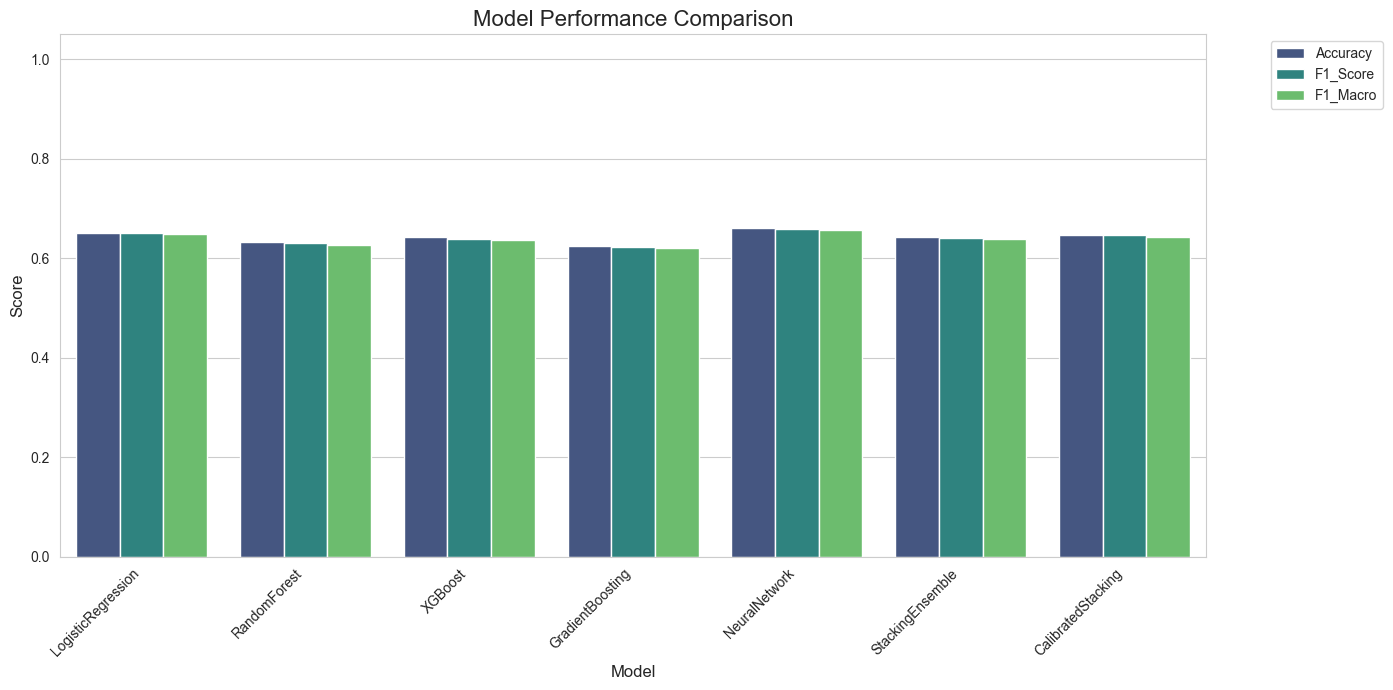


🏆 Best Model: NeuralNetwork
   F1 Score (Weighted): 0.6588
   F1 Score (Macro): 0.6561
   Accuracy: 0.6601
✓ Best model saved to: models\match_winner_best_model.joblib

✅ MATCH WINNER PIPELINE COMPLETED!


In [13]:
# Cell 11: Model Comparison
# ==================================================

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Build comparison dataframe
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

# Persist comparison
comparison_path = REPORTS_DIR / "model_comparison.csv"
metrics_df.to_csv(comparison_path, index=False)
print(f"\n✓ Comparison saved to: {comparison_path}")

# --- Visualization of Model Comparison ---
plt.figure(figsize=(14, 7))
# Melt for easier plotting with seaborn
metrics_melted = metrics_df.melt(id_vars='Model', value_vars=['Accuracy', 'F1_Score', 'F1_Macro'], var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted, palette='viridis')
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Select best model by F1 Score (weighted), break ties with F1 Macro, then Accuracy
metrics_df_sorted = metrics_df.sort_values(by=["F1_Score", "F1_Macro", "Accuracy"], ascending=False)
best_row = metrics_df_sorted.iloc[0]
best_model_name = best_row['Model']

print("\n🏆 Best Model:", best_model_name)
print(f"   F1 Score (Weighted): {best_row['F1_Score']:.4f}")
print(f"   F1 Score (Macro): {best_row['F1_Macro']:.4f}")
print(f"   Accuracy: {best_row['Accuracy']:.4f}")

best_model = best_models[best_model_name]
best_model_path = MODELS_DIR / "match_winner_best_model.joblib"
joblib.dump(best_model, best_model_path)
print(f"✓ Best model saved to: {best_model_path}")

# Save simple metadata for reproducibility
metadata = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "best_model": best_model_name,
    "metrics": best_row.to_dict(),
    "features_used": list(X_train.columns),
    "random_state": RANDOM_STATE
}

metadata_path = MODELS_DIR / "ps4_match_winner_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print("\n" + "="*80)
print("✅ MATCH WINNER PIPELINE COMPLETED!")
print("="*80)